In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics
# !pip install wandb # My trial Expired. You may use if required
import shutil
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd
from google.colab.patches import cv2_imshow
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 51.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
base_path = '/content/drive/MyDrive/ATSD'

In [ ]:
import os
os.chdir(base_path)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/MyDrive/ATSD


Run the Belo blok if you want to use Wandb. if not skip it

In [ ]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback
from ultralytics import settings
settings
# settings.update({'wandb': True})

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


{'settings_version': '0.0.6',
 'datasets_dir': '/content/datasets',
 'weights_dir': 'weights',
 'runs_dir': 'runs',
 'uuid': '569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb',
 'sync': True,
 'api_key': '',
 'openai_api_key': '',
 'clearml': True,
 'comet': True,
 'dvc': True,
 'hub': True,
 'mlflow': True,
 'neptune': True,
 'raytune': True,
 'tensorboard': True,
 'wandb': False,
 'vscode_msg': True}

The below code is for extracting the zip_data file, only needs to run one time, then comment it

In [ ]:
!unzip -o ATSD_v1_0.zip > /dev/null
print('Done')

Done


#Data Preprocessing/Preperation and Understanding

In [ ]:
txt_csv_paths = [os.path.join('ATSD_V1_0_signs_scenes/scenes/train/meta_train.csv'), os.path.join('ATSD_V1_0_signs_scenes/scenes/test/meta_test.csv')]

# Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Loop through each file path, read the CSV, and append to the combined DataFrame
for txt_file_path in txt_csv_paths:
    file_data = pd.read_csv(txt_file_path)
    combined_data = pd.concat([combined_data, file_data], ignore_index=True)

# we made a single csv file that contains all the labels id.
print(combined_data.columns)

# now we drop all the columns except the one below
columns_to_keep = ['image_id', 'xtl', 'ytl', 'xbr', 'ybr', 'class_id']
labels = combined_data[columns_to_keep]

labels.columns

Index(['Unnamed: 0', 'image_id', 'annotation_id', 'xtl', 'ytl', 'xbr', 'ybr',
       'group_id', 'type', 'not_normal_to_roadway', 'unusual_sign',
       'crossed_out', 'weather', 'lighting', 'fog', 'tunnel', 'damaged',
       'trimmed', 'covered', 'multiple_signs_visible', 'caption', 'class_id'],
      dtype='object')


Index(['image_id', 'xtl', 'ytl', 'xbr', 'ybr', 'class_id'], dtype='object')

In [ ]:
labels.head()

image_id     xtl     ytl    xbr     ybr class_id
0        10  901.04  308.06  934.4  356.60    05_06
1        10  521.46   17.48  596.6   91.40    08_01
2        11  955.94  286.25  975.1  305.40    01_01
3        11  530.20   31.55  592.9  113.14    08_01
4        11  377.82   41.60  441.6  123.19    08_01

Filtering out Classes

In [ ]:
# the class id is in the form 05_06. however. where 05 in the main class and 06 is the subclass. we will be classifying the data on main CLass
labels["detection_class_id"] = labels["class_id"].str.split('_').str[0]

<ipython-input-22-ab475157f449>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["detection_class_id"] = labels["class_id"].str.split('_').str[0]


In [ ]:
filter_detection_classes = ["xx","09"]
labels = labels[~labels['detection_class_id'].isin(filter_detection_classes)] # removes the class xx and 09, as they are additional
labels['detection_class_id'] = labels['detection_class_id'].astype(int) # converting to ints

<ipython-input-23-6805a611413e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['detection_class_id'] = labels['detection_class_id'].astype(int) # converting to ints


In [ ]:
labels.drop(columns=['class_id'], inplace=True)
labels.head()

<ipython-input-24-f8e1cc92225b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.drop(columns=['class_id'], inplace=True)


image_id     xtl     ytl    xbr     ybr  detection_class_id
0        10  901.04  308.06  934.4  356.60                   5
1        10  521.46   17.48  596.6   91.40                   8
2        11  955.94  286.25  975.1  305.40                   1
3        11  530.20   31.55  592.9  113.14                   8
4        11  377.82   41.60  441.6  123.19                   8

In [ ]:
labels['detection_class_id'].value_counts()

detection_class_id
1    9743
7    2950
8    2444
5    1140
2     758
4     395
3     313
6     207
Name: count, dtype: int64

In [ ]:
class_mapping = {
    1: 'prohibitory',
    2: 'danger',
    3: 'priority',
    4: 'mandatory',
    5: 'special',
    6: 'lane',
    7: 'additional',
    8: 'inactive'
}

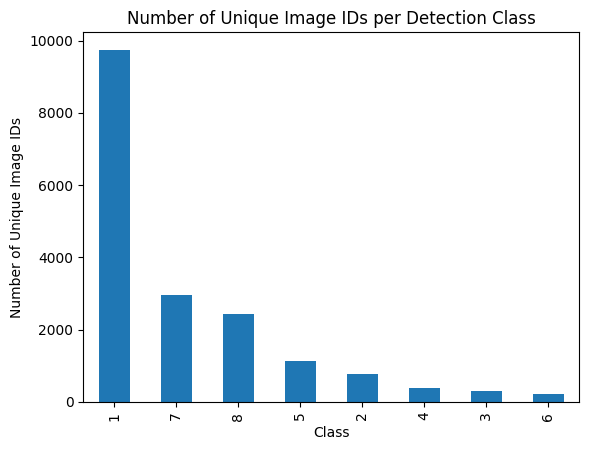

In [ ]:
labels['detection_class_id'].value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Unique Image IDs')
plt.title('Number of Unique Image IDs per Detection Class')
plt.show()

In [ ]:
labels['detection_class_id'] = labels['detection_class_id']-1 # because in classification. classes start at 0, not 1
labels['detection_class_id'].unique()

array([4, 7, 0, 6, 2, 3, 5, 1])

In [ ]:
# we have the 5346 unique image_ids in the labels cvs
print('Number of Unique Image IDs: ',len(labels['image_id'].unique()))

Number of Unique Image IDs:  5346


Importing all the Images_paths

In [ ]:
# list of test images
X_test = []
for img in os.listdir('ATSD_V1_0_signs_scenes/scenes/test/imgs'):
  temp = os.path.join('ATSD_V1_0_signs_scenes/scenes/test/imgs', img)
  X_test.append(temp)


# for train and validation images
X = []
for img in os.listdir('ATSD_V1_0_signs_scenes/scenes/train/imgs'):
  temp = os.path.join('ATSD_V1_0_signs_scenes/scenes/train/imgs', img)
  X.append(temp)

In [ ]:
print('Number of Test Images: ',len(X_test))
print("Number of Test+Val Images: ", len(X))
print('Number of Total Images: ',len(X_test) + len(X))

Number of Test Images:  1443
Number of Test+Val Images:  4068
Number of Total Images:  5511


Image id is  1009
      image_id     xtl     ytl     xbr     ybr  detection_class_id
1773      1009  924.84  287.17  958.36  335.42                   4
1774      1009  219.95   37.36  306.48  134.80                   7
1775      1009  405.69   26.53  492.22  123.96                   7
1776      1009  127.83   41.07  214.36  138.50                   7
1777      1009  312.08   31.45  398.61  128.89                   7
1778      1009  687.49   16.67  773.00  109.20                   7
1779      1009  594.38   17.16  680.91  114.60                   7
1780      1009  499.29   22.58  585.82  120.02                   7
Image Width:  1596
Image Height:  1196


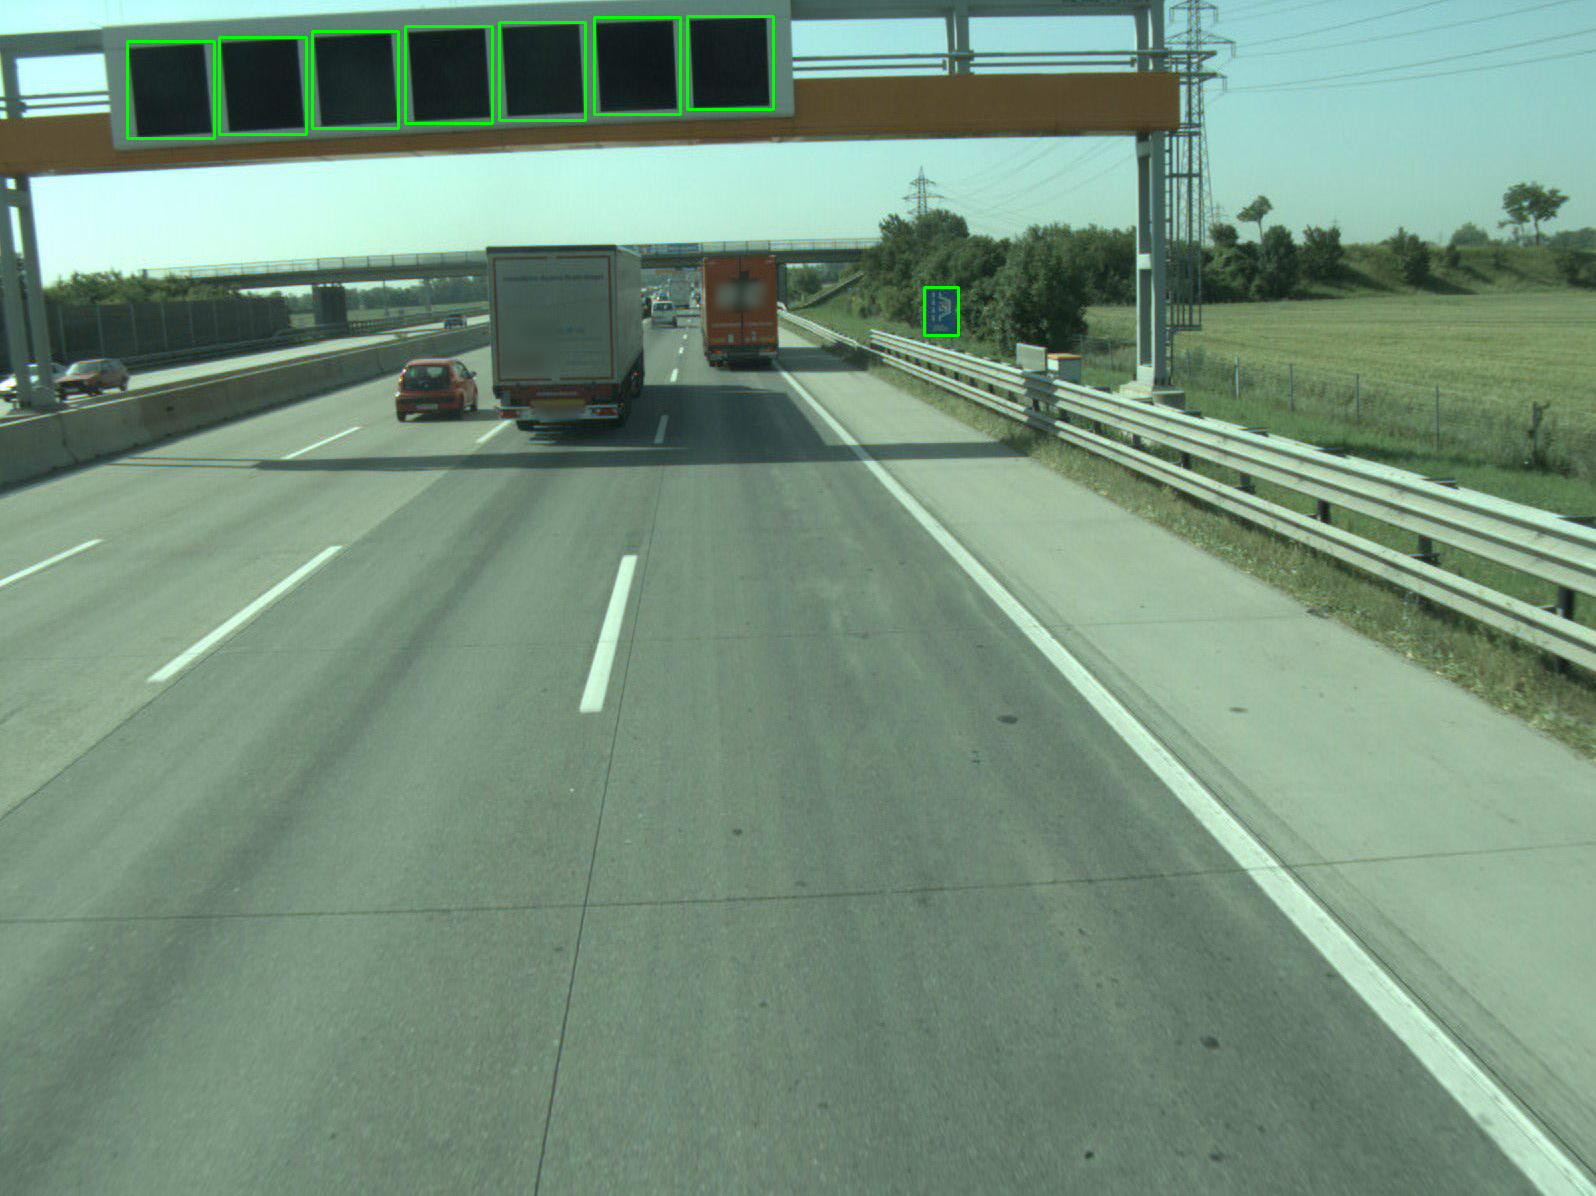

Image id is  1097
      image_id      xtl     ytl      xbr     ybr  detection_class_id
1893      1097  1321.36  360.60  1439.90  480.51                   0
1894      1097  1305.95  472.48  1432.56  557.55                   6
Image Width:  1596
Image Height:  1196


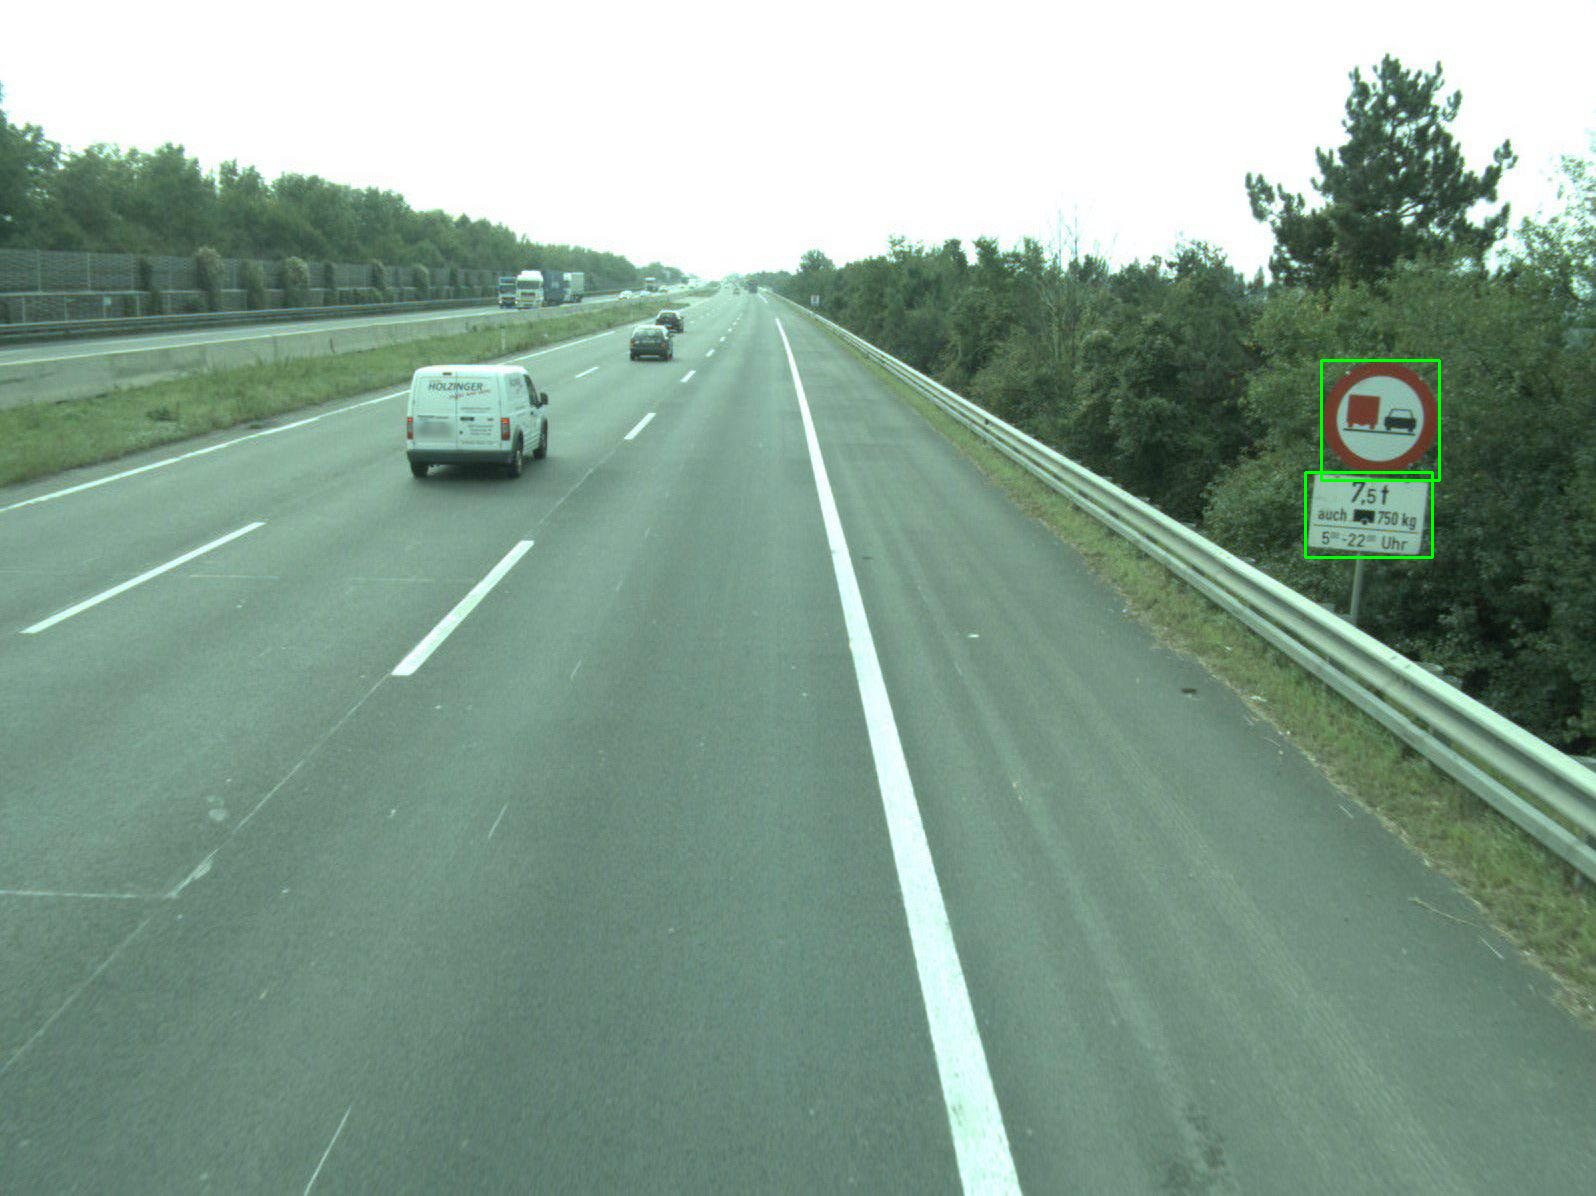

Image id is  1267
      image_id      xtl     ytl      xbr     ybr  detection_class_id
1935      1267  1183.83  403.65  1258.13  481.83                   0
1936      1267   134.47  304.24   218.80  387.60                   0
1937      1267  1188.79  311.84  1268.50  397.58                   0
1938      1267   131.14  206.88   215.40  294.60                   0
Image Width:  1596
Image Height:  1196


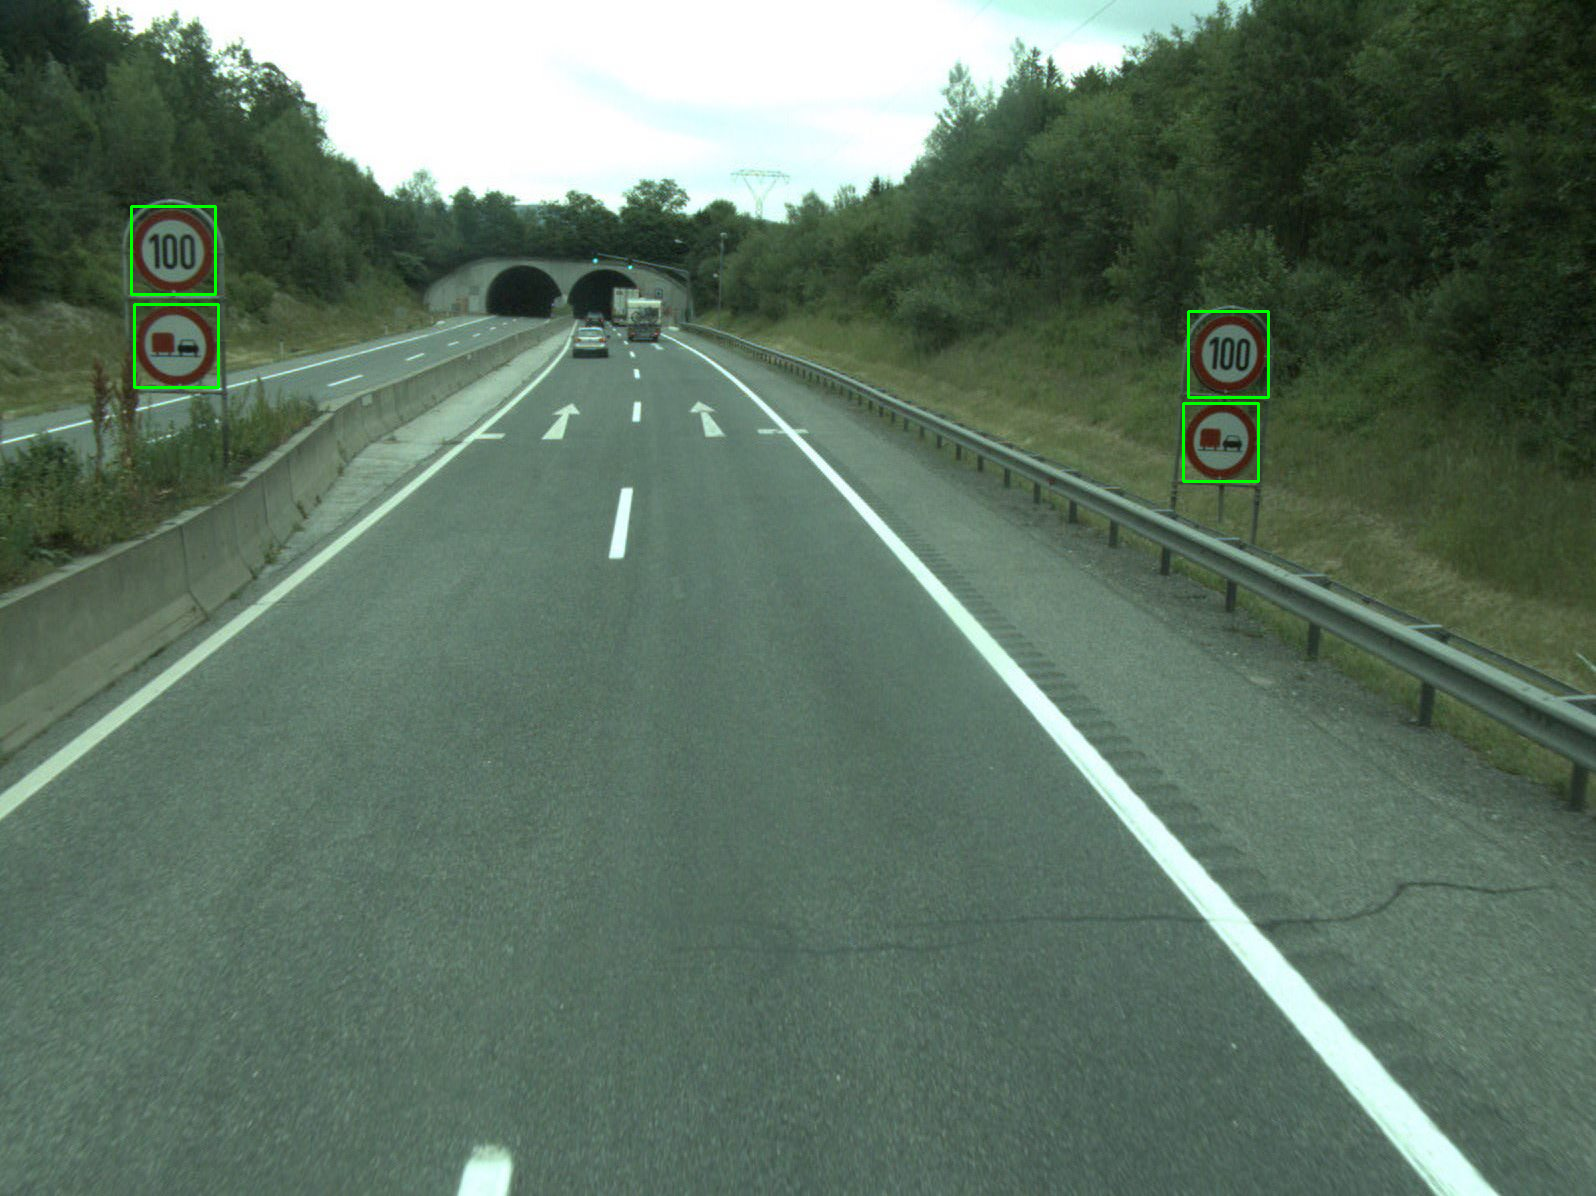

In [ ]:
def draw_labels(image_path, Labels_file):
    image = cv2.imread(image_path)

    image_id = image_path.split('/')[-1].split('.')[0]
    print('Image id is ', image_id)
    labels_for_image = Labels_file[Labels_file['image_id'] == int(image_id)]
    print(labels_for_image)
    print('Image Width: ', image.shape[1])
    print('Image Height: ', image.shape[0])

    for index, row in labels_for_image.iterrows():
        xtl = int(row['xtl'])
        ytl = int(row['ytl'])
        xbr = int(row['xbr'])
        ybr = int(row['ybr'])
        cv2.rectangle(image, (xtl, ytl), (xbr, ybr), (0, 255, 0), 2)
    cv2_imshow(image)

draw_labels(X[10],labels)
draw_labels(X[30],labels)
draw_labels(X[60],labels)

In [ ]:
X_train, X_val = train_test_split(X, test_size=0.25, stratify=[labels[labels['image_id'] == int(img_path.split('/')[-1].split('.')[0])]['detection_class_id'].values[0] if not labels[labels['image_id'] == int(img_path.split('/')[-1].split('.')[0])].empty else -1 for img_path in X], random_state=42)
X_test = X_test
print('Length of X_train:',len(X_train))
print('Length of X_test:', len(X_test)) # Test Data is the same
print('Length of X_val:', len(X_val))
print("total Number if images with no detections", - len(labels['image_id'].unique()) + len(X_train) + len(X_val) + len(X_test))

Length of X_train: 3051
Length of X_test: 1443
Length of X_val: 1017
total Number if images with no detections 165


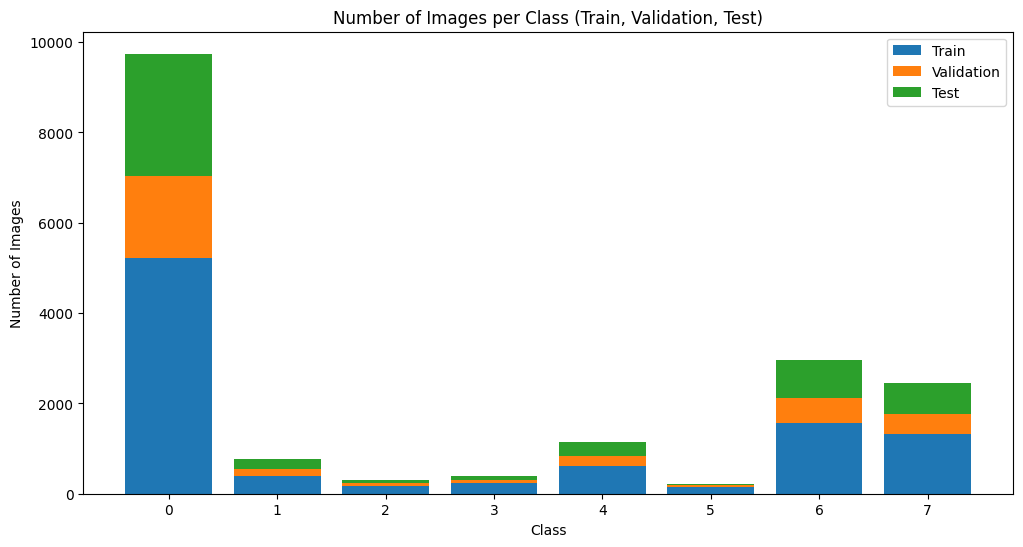

In [ ]:
train_counts = labels[labels['image_id'].isin([int(img_path.split('/')[-1].split('.')[0]) for img_path in X_train])]['detection_class_id'].value_counts().sort_index()
val_counts = labels[labels['image_id'].isin([int(img_path.split('/')[-1].split('.')[0]) for img_path in X_val])]['detection_class_id'].value_counts().sort_index()
test_counts = labels[labels['image_id'].isin([int(img_path.split('/')[-1].split('.')[0]) for img_path in X_test])]['detection_class_id'].value_counts().sort_index()

plt.figure(figsize=(12, 6))


plt.bar(train_counts.index, train_counts.values , label='Train')
plt.bar(val_counts.index, val_counts.values, bottom=train_counts.values, label='Validation')
plt.bar(test_counts.index, test_counts.values, bottom=[train_counts.get(i, 0) + val_counts.get(i, 0) for i in test_counts.index], label='Test')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class (Train, Validation, Test)')
plt.xticks(train_counts.index)
plt.legend()
plt.show()

In [ ]:
folders = ['train', 'val', 'test']
for folder in folders:
    os.makedirs(os.path.join('yolo_export//images', folder), exist_ok=True)
    os.makedirs(os.path.join('yolo_export//labels', folder), exist_ok=True)

In [ ]:
def convert_box_sizes_to_yolo_format(image_path, detections):
  # extract the width and height of the image
  imh, imw = np.array(cv2.imread(image_path).shape[:2]).astype("float32")
  # print(imw, imh


  center_x = ((detections["xtl"]+ detections["xbr"]) / 2 / imw).tolist()
  center_y = ((detections["ytl"]+ detections["ybr"]) / 2 /imh).tolist()
  width = ((detections["xbr"] - detections["xtl"]) / imw).tolist()
  height = ((detections["ybr"] - detections["ytl"]) / imh).tolist()


  class_id = (detections["detection_class_id"]).tolist()

  # <object-class> <x_center> <y_center> <width> <height>
  return list(zip(class_id, center_x, center_y, width, height))

In [ ]:
from tqdm import tqdm

for img_list, folder_name in zip([X_train, X_val, X_test], ['train', 'val', 'test']):

  for image_path in tqdm(img_list, desc=f"Processing {folder_name} images"):
    shutil.copy(image_path, os.path.join('yolo_export/images', folder_name))

    image_id = os.path.basename(image_path).split('.')[0]
    annotations = labels[labels["image_id"] == int(image_id)]
    annotations = convert_box_sizes_to_yolo_format(image_path, annotations)

    with open(os.path.join('yolo_export/labels', folder_name, f"{image_id}.txt"), "w") as annotation_file:
        for row in annotations:
            annotation_file.write(" ".join(map(str, row)) + "\n")

Processing test images: 100%|██████████| 1443/1443 [01:06<00:00, 21.65it/s]


In [ ]:
print('Images/train',len(os.listdir(os.path.join(base_path,'yolo_export/images/train'))))
print('Labels/train',len(os.listdir(os.path.join(base_path,'yolo_export/labels/train'))))
print('Images/test',len(os.listdir(os.path.join(base_path,'yolo_export/images/test'))))
print('Labels/test',len(os.listdir(os.path.join(base_path,'yolo_export/labels/test'))))
print('Images/val',len(os.listdir(os.path.join(base_path,'yolo_export/images/val'))))
print('Labels/val',len(os.listdir(os.path.join(base_path,'yolo_export/labels/val'))))

Images/train 3051
Labels/train 3051
Images/test 1443
Labels/test 1443
Images/val 1017
Labels/val 1017


-----------------------------------------------------------------------------------------------
Run the above section one time only.


it was just for preperation of dataset in the yaml format and understanding the data

*All*'s Good

#Start Training
--------------------------------------------------------------------------------

In [ ]:
model = YOLO(os.path.join(base_path,'yolov8n.pt'))

In [ ]:
dataset_yaml = f"""
path: {base_path}
train: yolo_export/images/train
val: yolo_export/images/val
test: yolo_export/images/test

nc: 8
names:
  0: prohibitory
  1: danger
  2: priority
  3: mandatory
  4: special
  5: lane
  6: additional_panel
  7: inactive
"""

with open(os.path.join(base_path, 'Yolo_train.yaml'), 'w') as f:
    f.write(dataset_yaml)

In [ ]:
results = model.train(
    data=os.path.join(base_path, 'Yolo_train.yaml'),

    project="Austrian-Traffic-Sign",
    name='YOLO_v8_1st_checkpoint',

    epochs=40,
    imgsz=1024,
    batch=32,
    optimizer='AdamW',

    # patience=20,

    # momentum=0.85,
    weight_decay=0.00005,
    lr0=0.001,
    cos_lr = True,

    plots=True,
    verbose = True,

    augment=True,
    mosaic = 1,
    flipud = 0.5,
    fliplr = 0.5,
    hsv_h = 0.015,
    hsv_s = 0.7,
    hsv_v = 0.4,

    save_period = 5
    )

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/ATSD/yolov8n.pt, data=/content/drive/MyDrive/ATSD/Yolo_train.yaml, epochs=40, time=None, patience=100, batch=32, imgsz=1024, save=True, save_period=5, cache=False, device=None, workers=8, project=Austrian-Traffic-Sign, name=YOLO_v8_1st_checkpoint3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False,

train: Scanning /content/drive/MyDrive/ATSD/yolo_export/labels/train.cache... 3051 images, 99 backgrounds, 0 corrupt: 100%|██████████| 3051/3051 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/ATSD/yolo_export/labels/val.cache... 1017 images, 33 backgrounds, 0 corrupt: 100%|██████████| 1017/1017 [00:00<?, ?it/s]


Plotting labels to Austrian-Traffic-Sign/YOLO_v8_1st_checkpoint3/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=5e-05), 63 bias(decay=0.0)


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to Austrian-Traffic-Sign/YOLO_v8_1st_checkpoint3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      10.7G     0.9494      1.966     0.9198         44       1024: 100%|██████████| 96/96 [03:43<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

                   all       1017       3390      0.704      0.233      0.304      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      10.5G     0.8409      0.919     0.9037         71       1024: 100%|██████████| 96/96 [03:30<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:39<00:00,  2.50s/it]

                   all       1017       3390      0.598      0.443      0.465      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      10.4G     0.8032     0.7925     0.8977         57       1024: 100%|██████████| 96/96 [03:20<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:34<00:00,  2.16s/it]

                   all       1017       3390      0.586      0.488      0.521       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      10.5G     0.8028     0.7361     0.8986         31       1024: 100%|██████████| 96/96 [03:08<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:35<00:00,  2.21s/it]

                   all       1017       3390       0.63       0.51      0.541      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      10.5G     0.7916     0.6936     0.8944         36       1024: 100%|██████████| 96/96 [03:09<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:34<00:00,  2.16s/it]

                   all       1017       3390      0.721      0.589      0.642      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      10.4G     0.7626     0.6454     0.8884         83       1024: 100%|██████████| 96/96 [03:15<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:31<00:00,  1.97s/it]


                   all       1017       3390      0.776      0.549       0.68      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      10.3G     0.7523     0.6071     0.8795         47       1024: 100%|██████████| 96/96 [03:14<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:41<00:00,  2.62s/it]

                   all       1017       3390      0.718      0.689      0.737       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      10.3G     0.7549     0.5983     0.8803         66       1024: 100%|██████████| 96/96 [03:11<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:38<00:00,  2.40s/it]

                   all       1017       3390       0.75      0.644      0.709      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      10.4G     0.7447     0.5762     0.8788         48       1024: 100%|██████████| 96/96 [03:10<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:34<00:00,  2.13s/it]


                   all       1017       3390      0.737      0.697      0.744      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      10.5G     0.7327     0.5502      0.881         33       1024: 100%|██████████| 96/96 [03:12<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:34<00:00,  2.13s/it]

                   all       1017       3390      0.781      0.684      0.756      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      10.6G     0.7253     0.5441     0.8734         71       1024: 100%|██████████| 96/96 [03:13<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:34<00:00,  2.14s/it]

                   all       1017       3390      0.792      0.677      0.758       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      10.4G       0.72     0.5345     0.8712         40       1024: 100%|██████████| 96/96 [03:12<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:37<00:00,  2.35s/it]

                   all       1017       3390      0.815      0.711      0.783      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      10.4G     0.7181     0.5238     0.8695         39       1024: 100%|██████████| 96/96 [03:13<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:33<00:00,  2.12s/it]

                   all       1017       3390       0.83      0.714      0.786       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      10.5G     0.7119     0.5207     0.8684         31       1024: 100%|██████████| 96/96 [03:14<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

                   all       1017       3390      0.839      0.712      0.795      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      10.5G      0.709     0.5091     0.8675         52       1024: 100%|██████████| 96/96 [03:18<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]

                   all       1017       3390      0.866      0.744      0.818      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      10.4G     0.6963       0.49     0.8642         45       1024: 100%|██████████| 96/96 [03:13<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:39<00:00,  2.46s/it]

                   all       1017       3390       0.87      0.693      0.805       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      10.4G     0.6991     0.4961     0.8627         78       1024: 100%|██████████| 96/96 [03:16<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:39<00:00,  2.49s/it]

                   all       1017       3390      0.867      0.714      0.821      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      10.4G     0.6817     0.4822      0.861         62       1024: 100%|██████████| 96/96 [03:15<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:36<00:00,  2.27s/it]

                   all       1017       3390      0.841      0.749      0.828      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      10.4G     0.6871     0.4672     0.8612         42       1024: 100%|██████████| 96/96 [03:09<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

                   all       1017       3390      0.875      0.749      0.833       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      10.4G     0.6754     0.4596     0.8567         48       1024: 100%|██████████| 96/96 [03:14<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:35<00:00,  2.23s/it]

                   all       1017       3390      0.854      0.788      0.842      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      10.4G     0.6712     0.4461     0.8559         54       1024: 100%|██████████| 96/96 [03:12<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

                   all       1017       3390      0.897      0.744      0.843      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      10.4G     0.6726     0.4464      0.856         44       1024: 100%|██████████| 96/96 [03:12<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:35<00:00,  2.24s/it]

                   all       1017       3390      0.902      0.768      0.846       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      10.4G     0.6683     0.4406     0.8553         73       1024: 100%|██████████| 96/96 [03:19<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:38<00:00,  2.42s/it]

                   all       1017       3390      0.922      0.754      0.849      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      10.4G     0.6546     0.4262     0.8479         59       1024: 100%|██████████| 96/96 [03:11<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:34<00:00,  2.18s/it]

                   all       1017       3390      0.927      0.751       0.86       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      10.4G     0.6551     0.4303     0.8504         38       1024: 100%|██████████| 96/96 [03:08<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:38<00:00,  2.39s/it]

                   all       1017       3390      0.914      0.767       0.86      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      10.4G      0.646     0.4173     0.8512         40       1024: 100%|██████████| 96/96 [03:14<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:44<00:00,  2.79s/it]

                   all       1017       3390       0.91      0.766      0.853      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      10.3G     0.6425       0.41     0.8489         41       1024: 100%|██████████| 96/96 [03:13<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:42<00:00,  2.69s/it]

                   all       1017       3390      0.904      0.772      0.859      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      10.4G      0.641     0.4062     0.8438         48       1024: 100%|██████████| 96/96 [03:11<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:40<00:00,  2.52s/it]

                   all       1017       3390      0.919      0.777      0.862      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      10.3G     0.6422     0.4024     0.8464         72       1024: 100%|██████████| 96/96 [03:13<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:36<00:00,  2.27s/it]

                   all       1017       3390      0.909      0.807      0.872      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      10.4G     0.6288       0.39     0.8434         65       1024: 100%|██████████| 96/96 [03:15<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:35<00:00,  2.24s/it]

                   all       1017       3390      0.888      0.802      0.869      0.647


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      10.3G     0.6255     0.3949     0.8464         25       1024: 100%|██████████| 96/96 [03:36<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:31<00:00,  1.99s/it]

                   all       1017       3390      0.874      0.809      0.865       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      10.4G     0.6153      0.381     0.8471         27       1024: 100%|██████████| 96/96 [03:02<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

                   all       1017       3390      0.927      0.771      0.865      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      10.3G     0.6106     0.3684     0.8432         33       1024: 100%|██████████| 96/96 [03:02<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:32<00:00,  2.04s/it]

                   all       1017       3390      0.876       0.81      0.868      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      10.3G     0.6075     0.3706     0.8413         23       1024: 100%|██████████| 96/96 [03:04<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]

                   all       1017       3390      0.907      0.804      0.872      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      10.3G     0.6019     0.3638     0.8392         40       1024: 100%|██████████| 96/96 [02:59<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:29<00:00,  1.85s/it]

                   all       1017       3390      0.891      0.806      0.873      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      10.3G     0.5987      0.356     0.8417         32       1024: 100%|██████████| 96/96 [03:04<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:33<00:00,  2.12s/it]

                   all       1017       3390      0.908      0.797      0.873      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      10.4G     0.5913     0.3547     0.8374         19       1024: 100%|██████████| 96/96 [02:58<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:39<00:00,  2.45s/it]

                   all       1017       3390      0.895      0.808      0.874      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      10.3G     0.5932     0.3528     0.8378         36       1024: 100%|██████████| 96/96 [02:58<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:38<00:00,  2.40s/it]

                   all       1017       3390      0.902      0.804      0.873      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      10.3G     0.5957     0.3517     0.8393         28       1024: 100%|██████████| 96/96 [03:01<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:37<00:00,  2.33s/it]

                   all       1017       3390      0.896      0.808      0.873      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      10.3G      0.588     0.3496     0.8381         24       1024: 100%|██████████| 96/96 [03:03<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:35<00:00,  2.19s/it]

                   all       1017       3390        0.9      0.805      0.873      0.663



40 epochs completed in 2.580 hours.
Optimizer stripped from Austrian-Traffic-Sign/YOLO_v8_1st_checkpoint3/weights/last.pt, 6.3MB
Optimizer stripped from Austrian-Traffic-Sign/YOLO_v8_1st_checkpoint3/weights/best.pt, 6.3MB

Validating Austrian-Traffic-Sign/YOLO_v8_1st_checkpoint3/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:09<00:00,  4.37s/it]


                   all       1017       3390      0.905      0.789      0.866      0.657
           prohibitory        855       1815      0.961      0.956      0.983      0.858
                danger         92        161      0.911      0.727      0.813      0.631
              priority         61         65      0.838      0.636      0.729      0.485
             mandatory         64         73      0.857      0.739      0.875      0.641
               special        169        221      0.883      0.817      0.888      0.675
                  lane         19         46      0.995      0.717        0.8      0.484
      additional_panel        329        553      0.883      0.792      0.878       0.62
              inactive        175        456       0.91      0.927      0.963      0.863
Speed: 0.5ms preprocess, 13.8ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to Austrian-Traffic-Sign/YOLO_v8_1st_checkpoint3


In [ ]:
model.save('ASTD_YOLOn_check1.pt')

# you can import the model again using below
# model_path = ''
# model = YOLO()

# Retraining, (Aint got enough compute resource to complete in one run)

In [ ]:
model = YOLO('ASTD_YOLOn_check1.pt')

results = model.train(
    data=os.path.join(base_path, 'Yolo_train.yaml'),

    project="Austrian-Traffic-Sign",
    name='YOLO_v8_2nd_checkpoint',

    epochs=30,
    imgsz=1024,
    batch=32,
    optimizer='AdamW',

    # patience=20,
    # momentum=0.85,
    weight_decay=0.00005,
    lr0=0.001,
    cos_lr = True,

    plots=True,
    verbose = True,

    augment=True,
    mosaic = 1,
    flipud = 0.5,
    fliplr = 0.5,
    hsv_h = 0.015,
    hsv_s = 0.7,
    hsv_v = 0.4,
    )

model.save('ASTD_YOLOn_check2.pt')

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=ASTD_YOLOn_check1.pt, data=/content/drive/MyDrive/ATSD/Yolo_train.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=Austrian-Traffic-Sign, name=YOLO_v8_2nd_checkpoint2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False,

100%|██████████| 755k/755k [00:00<00:00, 84.2MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/drive/MyDrive/ATSD/yolo_export/labels/train.cache... 3051 images, 99 backgrounds, 0 corrupt: 100%|██████████| 3051/3051 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/ATSD/yolo_export/labels/val.cache... 1017 images, 33 backgrounds, 0 corrupt: 100%|██████████| 1017/1017 [00:00<?, ?it/s]


Plotting labels to Austrian-Traffic-Sign/YOLO_v8_2nd_checkpoint2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=5e-05), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to Austrian-Traffic-Sign/YOLO_v8_2nd_checkpoint2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      10.5G     0.6437     0.4183     0.8455         44       1024: 100%|██████████| 96/96 [34:01<00:00, 21.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [06:42<00:00, 25.13s/it]

                   all       1017       3390      0.825      0.739      0.824      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      10.5G     0.6705     0.4527     0.8538         71       1024: 100%|██████████| 96/96 [21:17<00:00, 13.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [05:57<00:00, 22.37s/it]

                   all       1017       3390      0.846      0.764      0.827      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      10.3G     0.6806     0.4552     0.8565         57       1024: 100%|██████████| 96/96 [19:12<00:00, 12.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [05:43<00:00, 21.45s/it]

                   all       1017       3390      0.881      0.713      0.814      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      10.4G     0.6895     0.4732     0.8597         31       1024: 100%|██████████| 96/96 [18:28<00:00, 11.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [05:26<00:00, 20.39s/it]

                   all       1017       3390      0.818      0.695      0.781      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      10.4G      0.694     0.4819     0.8635         36       1024: 100%|██████████| 96/96 [17:57<00:00, 11.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [05:16<00:00, 19.77s/it]

                   all       1017       3390      0.877      0.734      0.823      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      10.3G     0.6744     0.4584     0.8575         83       1024: 100%|██████████| 96/96 [18:33<00:00, 11.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [05:19<00:00, 19.97s/it]

                   all       1017       3390      0.749      0.763      0.828      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      10.2G     0.6812     0.4564     0.8548         47       1024: 100%|██████████| 96/96 [17:32<00:00, 10.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [05:27<00:00, 20.46s/it]

                   all       1017       3390      0.882      0.755      0.832      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      10.2G     0.6788     0.4559     0.8564         66       1024: 100%|██████████| 96/96 [17:33<00:00, 10.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 12/16 [03:39<01:26, 21.52s/it]

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Training End

# Performance on Val Data

In [ ]:
val_results = model.val(plots = True)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/ATSD/yolo_export/labels/val.cache... 1017 images, 33 backgrounds, 0 corrupt: 100%|██████████| 1017/1017 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:27<00:00,  2.72s/it]


                   all       1017       3390      0.904       0.79      0.866      0.659
           prohibitory        855       1815      0.961      0.956      0.983      0.863
                danger         92        161       0.91      0.727      0.815      0.628
              priority         61         65      0.838      0.639      0.732      0.493
             mandatory         64         73      0.857      0.741      0.869      0.643
               special        169        221      0.878      0.819      0.888       0.68
                  lane         19         46      0.988      0.717      0.802       0.48
      additional_panel        329        553      0.889      0.793      0.878      0.621
              inactive        175        456       0.91      0.928      0.963      0.863
Speed: 0.6ms preprocess, 25.1ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to Austrian-Traffic-Sign/YOLO_v8_1st_checkpoint32




*   Inference Results



In [ ]:
Speed = {key: [value] for key, value in val_results.speed.items()}
pd.DataFrame(Speed, index=['Time in Milli-Second'])

preprocess  inference      loss  postprocess
Time in Milli-Second    0.580705  25.111451  0.001669     9.034171



*   Detection Results



In [ ]:
# MEAN_AVERAGE_PRECISION
print('The current minimum MAP Confidence Threshold is: ',val_results.confusion_matrix.conf)
print(val_results.box.map)
print('MAP at 50 conf: ', val_results.box.map50)
print('MAP at 75 conf: ', val_results.box.map75)
print('MAP for range of min to max: ',val_results.box.maps)

The current minimum MAP Confidence Threshold is:  0.25
0.6589775403043496
MAP at 50 conf:  0.8664443248436455
MAP at 75 conf:  0.7419505099960533
MAP for range of min to max:  [    0.86295      0.6284     0.49338     0.64286     0.67975     0.47958     0.62148     0.86343]


In [ ]:
# IOU THRESHOLD
print('The threshold for intersection over union is:',val_results.confusion_matrix.iou_thres)

The threshold for intersection over union is: 0.45


In [ ]:
Class_results = {key: [value] for key, value in val_results.results_dict.items()}

# Create DataFrame using modified dictionary and explicit index
pd.DataFrame(Class_results, index=[0])

metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0              0.903899           0.789994          0.866444   

   metrics/mAP50-95(B)   fitness  
0             0.658978  0.679724

# Performance on Test Data

In [ ]:
# this code just changes the test dataset to the val dataset for measuring performance on the test dataset
test_yaml = f"""
path: {base_path}
train: yolo_export/images/train
val: yolo_export/images/test

nc: 8
names:
  0: prohibitory
  1: danger
  2: priority
  3: mandatory
  4: special
  5: lane
  6: additional_panel
  7: inactive
"""

with open(os.path.join(base_path, 'test.yaml'), 'w') as f:
    f.write(test_yaml)

In [ ]:
test_results = model.val(data = '/content/drive/MyDrive/ATSD/test.yaml', plots = True)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/ATSD/yolo_export/labels/test... 1443 images, 33 backgrounds, 0 corrupt: 100%|██████████| 1443/1443 [00:25<00:00, 55.52it/s] 


val: New cache created: /content/drive/MyDrive/ATSD/yolo_export/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [01:22<00:00,  1.80s/it]


                   all       1443       4889      0.807      0.726      0.779      0.601
           prohibitory       1212       2714      0.952      0.945      0.974      0.861
                danger        135        203      0.832      0.759      0.819      0.597
              priority         69         76      0.741      0.602      0.672      0.463
             mandatory         74         84      0.849      0.736      0.782      0.593
               special        223        300      0.688      0.787      0.817      0.651
                  lane         17         23      0.729      0.352      0.445      0.248
      additional_panel        477        820      0.772      0.822      0.845      0.617
              inactive        261        669      0.892      0.804      0.883       0.78
Speed: 0.5ms preprocess, 19.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to Austrian-Traffic-Sign/YOLO_v8_1st_checkpoint33


- Inference Results

In [ ]:
Speed = {key: [value] for key, value in test_results.speed.items()}
pd.DataFrame(Speed, index=['Time in Milli-Second'])

preprocess  inference      loss  postprocess
Time in Milli-Second    0.534369  19.570199  0.004131     3.901711

- Detection Results

In [ ]:
# MEAN_AVERAGE_PRECISION
print('The current minimum MAP Confidence Threshold is: ',test_results.confusion_matrix.conf)
print(test_results.box.map)
print('MAP at 50 conf: ', test_results.box.map50)
print('MAP at 75 conf: ', test_results.box.map75)
print('MAP for range of min to max: ',test_results.box.maps)

The current minimum MAP Confidence Threshold is:  0.25
0.601199132572642
MAP at 50 conf:  0.7794054271923949
MAP at 75 conf:  0.6832667342352736
MAP for range of min to max:  [    0.86125     0.59731     0.46332     0.59279     0.65061     0.24791     0.61684     0.77956]


In [ ]:
Class_results = {key: [value] for key, value in test_results.results_dict.items()}

# Create DataFrame using modified dictionary and explicit index
pd.DataFrame(Class_results, index=[0])

metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0              0.806921           0.725847          0.779405   

   metrics/mAP50-95(B)  fitness  
0             0.601199  0.61902